In [1]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv

from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict  # TypedDict를 typing_extensions에서 import



# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.tools import tool

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import utils 
from agents.agent_library import agent_configs, AgentConfig
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf


In [2]:
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

MODEL_NAME = "gemma2-9b-it"

True


In [3]:
llm = ChatGroq(
    model=MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
# Polygon API를 초기화
polygon = PolygonAPIWrapper()
polygon_toolkit = PolygonToolkit.from_polygon_api_wrapper(polygon)
polygon_tools = polygon_toolkit.get_tools()


In [5]:
polygon_tools

[PolygonAggregates(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonLastQuote(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonTickerNews(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr')),
 PolygonFinancials(api_wrapper=PolygonAPIWrapper(polygon_api_key='Il8sVXYP3rj8_qxduX1XFSqR8MzW6KNr'))]

In [6]:
# 시장 조사 도구 
market_research_tools =  polygon_tools

# 시장 조사 에이전트
market_research_agent = create_react_agent(
    llm, 
    tools=market_research_tools, 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    print(f"market_result===={result}")
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )

In [7]:

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info

def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )



stock_research_tools = [get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)


In [15]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials( freq="quarterly")
    sec_filings = company_info.get_sec_filings()


    def filter_sec_filings(sec_filings, report_types=None):
        """
        SEC Filings에서 1년 이내 데이터만 가져오고, 특정 리포트 유형을 필터링하며, EXCEL 파일은 제외.
        
        - report_types가 None이면 모든 리포트를 가져옴
        - 특정 리스트가 들어오면 해당 유형만 필터링
        """
        one_year_ago = datetime.today() - timedelta(days=50)

        filtered_filings = []
        for filing in sec_filings:
            filing_date = parse(str(filing["date"]))  # 날짜 변환
            is_recent = filing_date >= one_year_ago
            is_valid_type = report_types is None or filing["type"] in report_types 
            
            if is_recent and is_valid_type:
                # EXCEL 파일을 제외한 exhibits 필터링
                filtered_exhibits = {key: value for key, value in filing["exhibits"].items() if key != "EXCEL"}
                
                filtered_filings.append({
                    "date": filing["date"],
                    "type": filing["type"],
                    "title": filing["title"],
                    "exhibits": filtered_exhibits  # 필터링된 exhibits 추가
                })
        
        return filtered_filings


    filtered_filings = filter_sec_filings(sec_filings)
    print("=-=====================================")
    return {
        'financial_info': financial_info,
        # 'sec_filings': filtered_filings
    }


def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )


company_research_tools = [company_research_tool]
company_research_agent = create_react_agent(
    llm, tools=company_research_tools, state_modifier='You are a company researcher. Provide facts only not opinions'
)


In [25]:
def filter_financial_info(financial_data: pd.DataFrame) -> pd.DataFrame:
    """
    손익계산서 데이터에서 핵심 지표만 필터링하는 함수
    
    :param financial_data: yfinance get_financials(freq="quarterly")로 가져온 데이터 (DataFrame)
    :return: 필터링된 DataFrame
    """
    # 남길 핵심 지표 리스트
    key_metrics = [
        "TotalRevenue", "CostOfRevenue", "GrossProfit", "OperatingIncome", "EBITDA", "EBIT", 
        "NetIncome", "BasicEPS", "DilutedEPS", "InterestExpense", "TaxProvision"
    ]
    
    # 필터링된 데이터 반환 (존재하는 지표만 남김)
    return financial_data.loc[financial_data.index.intersection(key_metrics)]



def company_research_tool(ticker: str) -> dict:
    """Given a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials( freq="quarterly")
    sec_filings = company_info.get_sec_filings()


    def filter_sec_filings(sec_filings, report_types=None):
        """
        SEC Filings에서 1년 이내 데이터만 가져오고, 특정 리포트 유형을 필터링하며, EXCEL 파일은 제외.
        
        - report_types가 None이면 모든 리포트를 가져옴
        - 특정 리스트가 들어오면 해당 유형만 필터링
        """
        one_year_ago = datetime.today() - timedelta(days=50)

        filtered_filings = []
        for filing in sec_filings:
            filing_date = parse(str(filing["date"]))  # 날짜 변환
            is_recent = filing_date >= one_year_ago
            is_valid_type = report_types is None or filing["type"] in report_types 
            
            if is_recent and is_valid_type:
                # EXCEL 파일을 제외한 exhibits 필터링
                filtered_exhibits = {key: value for key, value in filing["exhibits"].items() if key != "EXCEL"}
                
                filtered_filings.append({
                    "date": filing["date"],
                    "type": filing["type"],
                    "title": filing["title"],
                    "exhibits": filtered_exhibits  # 필터링된 exhibits 추가
                })
        
        return filtered_filings


    filtered_filings = filter_sec_filings(sec_filings)
    print("=-=====================================")
    return {
        'financial_info': financial_info,
        # 'sec_filings': filtered_filings
    }


In [26]:
company_research_tool("BE")

=-=====================================


{'financial_info':                                                           2024-12-31  \
 TaxEffectOfUnusualItems                                 -1368.176693   
 TaxRateForCalcs                                              0.00362   
 NormalizedEBITDA                                         135751000.0   
 TotalUnusualItems                                          -378000.0   
 TotalUnusualItemsExcludingGoodwill                         -378000.0   
 NetIncomeFromContinuingOperationNetMinorityInte...       104795000.0   
 ReconciledDepreciation                                    13883000.0   
 ReconciledCostOfRevenue                                  353076000.0   
 EBITDA                                                   135373000.0   
 EBIT                                                     121490000.0   
 NetInterestIncome                                        -11026000.0   
 InterestExpense                                           15951000.0   
 InterestIncome                  

In [16]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [17]:

from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [18]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()

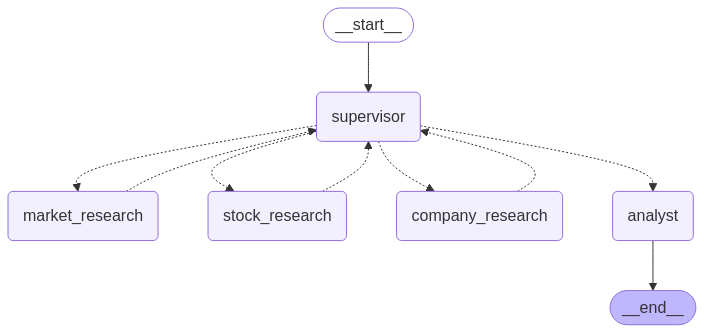

In [19]:
graph

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in Snowflake?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()